In [1]:
import sys
from pathlib import Path
p_link = Path("/public/workspace/licanchengup/link")
p_publish = p_link.joinpath("res_publish")
None if str(p_publish) in sys.path else sys.path.append(str(p_publish))

In [2]:
from func import *
# cm = mpl.colormaps.get_cmap('BuGn')
cm = plt.get_cmap("coolwarm")
item = 'healty_Retina'
fig_format = 'png'

/public/workspace/licanchengup/apps/miniconda3/envs/publish/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-24 16:48:02.376565: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# get res info

In [3]:
df = get_test_result_df(p_res)
df = df.query("tissue == 'retina'")
# df['p_ratio'] = df['dir'].apply(lambda x: x.joinpath('ratio.csv'))

df['is_1v1'] = ''
df['is_1v1'] = df['is_1v1'].mask(
    df['resdir_tag'].str.contains('is_1v1=True'), '_1v1').mask(
        df['model'] == 'Seurat', '')
df['model_mask'] = df.apply(
    lambda _: '{model}{is_1v1}'.format(
        **_), axis=1)


df['F1-score'] = df.apply(get_res_stat,
                          key='F1-score',
                          q="dataset_type == 'que'",
                          axis=1).mul(100).round(2)
df['Accuracy'] = df.apply(
    get_res_stat,
    key='Accuracy',
    q="dataset_type == 'que'",
    axis=1).mul(100).round(2)

df['time_tag'] = df['name'].str.extract(
    ';(\\d{6}-\\d{4})$', expand=False).fillna('')
df = df[df['time_tag'].str.len() == 0]
df = df.drop(columns=['time_tag'])

_temp = df.apply(
    lambda row: '{tissue};{sp_ref}{sp_que};{model_mask}'.format(
        **row), axis=1)
assert _temp.is_unique, '[isnot unique]'
df.index = _temp
del _temp
df.head(2)


[extract]
^(?P<tissue>.+)_(?P<sp_ref>.+)-corss-(?P<sp_que>.+);(?P<model>came|csMAHN|Seurat|SAMap);(?P<name_ref>[\w-]+)-map-(?P<name_que>[[\w-]+);?(?P<resdir_tag>.+)?$


/public/workspace/licanchengup/apps/miniconda3/envs/publish/lib/python3.9/site-packages/pandas/core/strings/accessor.py:2738: FutureWarning: Possible nested set at position 127
  regex = re.compile(pat, flags=flags)


,dir,name,tissue,sp_ref,sp_que,model,name_ref,name_que,resdir_tag,is_1v1,model_mask,F1-score,Accuracy
retina;zc;came,/public/workspace/licanchengup/link/res_publis...,retina_z-corss-c;came;zebrafish_Adult-map-chic...,retina,z,c,came,zebrafish_Adult,chicken_P10,epochs=500;is_1v1=False,,came,89.33,89.22
retina;zc;came_1v1,/public/workspace/licanchengup/link/res_publis...,retina_z-corss-c;came;zebrafish_Adult-map-chic...,retina,z,c,came,zebrafish_Adult,chicken_P10,epochs=500;is_1v1=True,_1v1,came_1v1,72.01,77.33


# heatmap

In [4]:
model_masks = 'Seurat,SAMap_1v1,SAMap,came_1v1,came,csMAHN_1v1,csMAHN'.split(
    ',')

## Accuracy

In [5]:
key = 'Accuracy'
df_plot = df.pivot(values=key,
                   index='model_mask',
                   columns='sp_que')
df_plot = df_plot.loc[[i for i in model_masks if i in df_plot.index], :]
df_plot = df_plot.rename(columns=map_sp)
display(
    df_plot.style.highlight_null()
    .set_properties(color='white')
    .background_gradient(cmap=cm, vmin=50, vmax=90)
    .format(lambda x: '{:.2f}%'.format(x))
)

sp_que,chicken,human,mouse
model_mask,,,
Seurat,54.21%,63.98%,76.42%
SAMap,85.71%,87.50%,69.20%
came_1v1,77.33%,85.35%,75.86%
came,89.22%,92.32%,90.14%
csMAHN_1v1,81.07%,78.04%,82.24%
csMAHN,92.88%,92.09%,90.71%


[out][plot] healty_Retina;heatmap;Accuracy.png 
	in /public/workspace/licanchengup/link/res_publish/plot


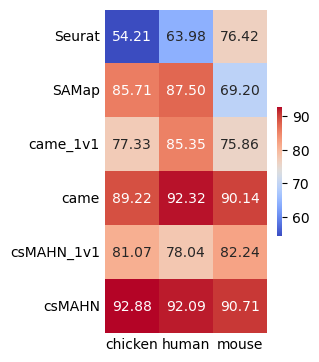

In [6]:
figsize = np.array([1, .618]) * 6.8
fig, ax = plt.subplots(figsize=figsize)
ax = sns.heatmap(
    data=df_plot,
    ax=ax,
    cmap=cm,
    square=True,
    annot=True,
    fmt=".2f",
    cbar=True,
    cbar_kws={
        'location': 'right',
        # 'orientation':'horizontal',
        'fraction': .1,
        'shrink': .4,
        'aspect': 25,
        'pad': 0.02
    }

)
ax.set_yticklabels(df_plot.index, fontdict={
    'rotation': 0,
}
)
ax.tick_params(axis='both', length=0)
ax.set(xlabel="", ylabel="")

# ax.set_title(key)
# ax.grid(visible=True)
savefig(fig,
        '{};{};{}.{}'.format(item, 'heatmap', key, fig_format)
       )

# F1-score

[out][plot] healty_Retina;heatmap;F1-score.png 
	in /public/workspace/licanchengup/link/res_publish/plot


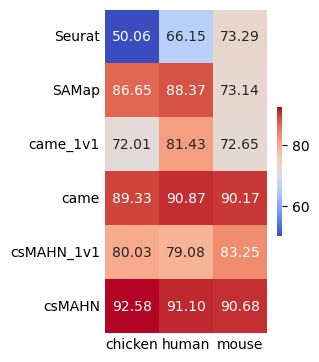

In [7]:
key = 'F1-score'
df_plot = df.pivot(values=key,
                   index='model_mask',
                   columns='sp_que')
df_plot = df_plot.loc[[i for i in model_masks if i in df_plot.index], :]
df_plot = df_plot.rename(columns=map_sp)
# display(
#     df_plot.style.highlight_null()
#     .set_properties(color='white')
#     .background_gradient(cmap=cm, vmin=50, vmax=90)
#     .format(lambda x: '{:.2f}%'.format(x))
# )

figsize = np.array([1, .618]) * 6.8
fig, ax = plt.subplots(figsize=figsize)
ax = sns.heatmap(
    data=df_plot,
    ax=ax,
    cmap=cm,
    square=True,
    annot=True,
    fmt=".2f",
    cbar=True,
    cbar_kws={
        'location': 'right',
        # 'orientation':'horizontal',
        'fraction': .1,
        'shrink': .4,
        'aspect': 25,
        'pad': 0.02
    }

)
ax.set_yticklabels(df_plot.index, fontdict={
    'rotation': 0,
}
)
ax.tick_params(axis='both', length=0)
ax.set(xlabel="", ylabel="")

# ax.set_title(key)
# ax.grid(visible=True)
savefig(fig,
        '{};{};{}.{}'.format(item, 'heatmap', key, fig_format)
       )